In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pylab
import glob, os
import scipy.stats as stats
from scipy.stats import gaussian_kde
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import chi2
from sklearn.metrics import r2_score
import timeit
%matplotlib inline

In [2]:
# Format to remove scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# options of samples

In [3]:
Sample = pd.read_csv('R:/Angela/fast_trips/SampleDataSpringFall_4day.csv')

In [4]:
Sample.shape

(407752, 58)

#my_data

In [5]:
my_data = Sample

In [6]:
#Or try a small sample if needed
'''
msk = np.random.rand(len(Sample)) < 0.95
my_data = Sample[~msk]
'''

'\nmsk = np.random.rand(len(Sample)) < 0.95\nmy_data = Sample[~msk]\n'

In [7]:
def content_need(data):
    data = data[['on', 'off', 'vehno', 'route', 'stop_name', 'stop_sequence', 'day', 'mo', 'yr', 
                 'arr_hour', 'arr_min', 'arr_sec', 'dep_hr', 'dep_min', 'dep_sec', 'load', 'capacity', 'date_id']]
    return data

In [8]:
test = content_need(my_data)

In [9]:
test.shape

(407752, 18)

In [10]:
test.columns

Index([u'on', u'off', u'vehno', u'route', u'stop_name', u'stop_sequence',
       u'day', u'mo', u'yr', u'arr_hour', u'arr_min', u'arr_sec', u'dep_hr',
       u'dep_min', u'dep_sec', u'load', u'capacity', u'date_id'],
      dtype='object')

#Prepare bus info

In [11]:
vehicles = pd.read_csv(r'R:\Angela\fast_trips\Vehicles.csv')
fleet = pd.read_csv(r'R:\Angela\fast_trips\Copy of Fleet.csv')
vehicles.Artic = vehicles.Length.map({"60'" : 1, "40'" : 0, "30'" : 0})
vehicles.Floor = vehicles['Low Floor'].map({'Y': 1, 'N' : 0})
vehicles.loc[:,'Artic'] = pd.Series(vehicles.Artic, index=vehicles.index)
vehicles.loc[:,'Floor'] = pd.Series(vehicles.Floor, index=vehicles.index)
df_artic = vehicles.set_index('Equip_Type').to_dict()['Artic']
df_floor = vehicles.set_index('Equip_Type').to_dict()['Floor']
df_doors = vehicles.set_index('Equip_Type').to_dict()['Doors']
fleet['Doors'] = fleet['Equip_Type'].map(df_doors)
fleet['Artic'] = fleet['Equip_Type'].map(df_artic)
fleet['Floor'] = fleet['Equip_Type'].map(df_floor)
df_vehnum_doors = fleet.set_index('VehNum').to_dict()['Doors']
df_vehnum_artic = fleet.set_index('VehNum').to_dict()['Artic']
df_vehnum_floor = fleet.set_index('VehNum').to_dict()['Floor']

# Prepare route type

In [12]:
route_type = pd.read_csv(r'R:\Angela\fast_trips\MuniRouteTypes.csv')
route_type = route_type.dropna()
dict_route_type = {}
dict_route_type = route_type.set_index('APC Route ID')['Type'].to_dict()

#Step1: Prepare basic variables

In [13]:
def get_x_y(data):
    start = timeit.default_timer()
    # Get rid of rows where certain fields has null/nan values
    data = data.dropna(subset = ['on', 'off', 'vehno'])

    # COMPUTE TIMESTOP=((HR * 3600) + (MIN * 60) + SEC)
    start = timeit.default_timer()
    data['COMPUTE_TIMESTOP'] = data['arr_hour']*3600 + data['arr_min']*60 + data['arr_sec']
    # COMPUTE DOORCLOSE=(( DHR * 3600) + (DMIN * 60) + DSEC)
    data['COMPUTE_DOORCOLSE'] = data['dep_hr']*3600 + data['dep_min']*60 + data['dep_sec']
    # COMPUTE DOORDWELL=DOORCLOSE - TIMESTOP
    data['COMPUTE_DOORDWELL'] = data['COMPUTE_DOORCOLSE'] - data['COMPUTE_TIMESTOP']
    # Appling door dwell time less than 120 secs
    data = data.loc[data['COMPUTE_DOORDWELL'] <= 120]
    stop = timeit.default_timer()
    print 'compute dwell time:', stop - start

    # Keep rows that satisfy a query:
    start = timeit.default_timer()
    data['Doors'] = data['vehno'].map(df_vehnum_doors) 
    data['Artic'] = data['vehno'].map(df_vehnum_artic)
    data['Floor'] = data['vehno'].map(df_vehnum_floor)
    data['two_doors'] = data['Doors'].map({2: 1, 3: 0})
    data['three_doors'] = data['Doors'].map({2: 0, 3: 1})
    data['all_door_boarding']= data.apply(lambda x: x['mo'] > 6, axis=1).map({False: 0, True: 1})
    
    # Create dummie variables for route id
    data['Route Type'] = data['route'].map(dict_route_type)
    just_dummies_route = pd.get_dummies(data['Route Type'])
    step_1 = pd.concat([data, just_dummies_route], axis=1)
    step_1.drop(['Local'], inplace=True, axis=1)
    data = step_1
    stop = timeit.default_timer()
    print 'add veh&route info:', stop - start

    # Create interaction variables
    start = timeit.default_timer()
    data['on_threedoors'] = data['on']*data['three_doors']
    data['off_threedoors'] = data['off']*data['three_doors']
    data['on_floor'] = data['on']*data['Floor']
    data['off_floor'] = data['off']*data['Floor']
    data['floor_threedoors'] = data['Floor']*data['three_doors']
    data['floor_twodoors'] = data['Floor']*data['two_doors']
    data['on_all_door_boarding'] = data['on']*data['all_door_boarding']
    data['off_all_door_boarding'] = data['off']*data['all_door_boarding']
    data['on_express'] = data['on']*data['Express']
    data['off_express'] = data['off']*data['Express']
    data['on_rapid'] = data['on']*data['Rapid']
    data['off_rapid'] = data['off']*data['Rapid']
    data['on_owl'] = data['on']*data['OWL']
    data['off_owl'] = data['off']*data['OWL']
    stop = timeit.default_timer()
    print 'add interaction variables:', stop - start

    return data

## Step2: Adding more passenger activity variables

In [14]:
def passenger_var(data):
    start = timeit.default_timer()
    data['max_pasg'] = data[['on', 'off']].max(axis=1)
    print 'data shape:', data.shape
    data['abs_pasg'] = (data['on'] - data['off']).abs()
    print 'data shape:', data.shape
    
    # A passenger friction factor was constructed to account for passenger activity on buses with standees. 
    # It was posited that heavily loaded buses have greater dwell times. 
    # STANDEES are the number of passengers when LOAD minus 60% of bus capacity is positive. 
    data['pre_load'] = data['load'].shift()
    data['pre_standees']= data['pre_load'] - 0.60 * data['capacity']
    data['pre_crowding']= data.apply(lambda x: x['pre_standees'] > 0, axis=1).map({False: 0, True: 1})
    # A proxy variable was constructed by adding ONS, OFFS, and STANDEES.
    data['friction'] = ((data['on'] + data['off'] + (data['pre_standees']).abs()) * data['pre_crowding']).abs()
    print 'data shape:', data.shape
    stop = timeit.default_timer()
    print 'add passenger activity variables:', stop - start

    # Remove the corner data, which is the first and last stop data
    start = timeit.default_timer()
    # COMPUTE EOL = RINDEX(ANAME,' - EOL') 
    data['EOL']= data.apply(lambda x: '- EOL' in x['stop_name'], axis=1).map({False: 1, True: 0})
    # Remove the last stop
    data = data.loc[data['EOL'] == 1]
    # Remove the first stop
    data = data.loc[data['stop_sequence'] != 1]
    stop = timeit.default_timer()
    print 'remove corner data:', stop - start
    
    return data

In [15]:
step1 = get_x_y(test)

compute dwell time: 0.107753917316
add veh&route info: 5.7047709286
add interaction variables: 0.0403318040677


In [16]:
step2 = passenger_var(step1)

data shape: (394302, 46)
data shape: (394302, 47)
data shape: (394302, 51)
add passenger activity variables: 5.91462393134
remove corner data: 6.04360867259


# Step3: Prepare vehicle ID variables

In [17]:
# Create dummie variables for bus id 
def create_vehID_day(data):
    start = timeit.default_timer()
    data['vehno_date'] = data.vehno.astype(str) + '_' + data.date_id.astype(str)
    #person_table['person_id'] = person_table.hh_id.astype(str) + '_' + person_table.pno.astype(str) 
    just_dummies_veh = pd.get_dummies(data['vehno_date'])
    data = pd.concat([data, just_dummies_veh], axis=1)
    #get rid of one dummy variable to avoid the dummy variable trap
    #step_1.drop([8515], inplace=True, axis=1)
    stop = timeit.default_timer()
    print 'data shape:', data.shape
    print 'add vehid&day variables:', stop - start
    
    return data

In [18]:
step3 = create_vehID_day(step2)

data shape: (385546, 776)
add vehid&day variables: 12.7518140347


In [19]:
step3.columns

Index([u'on', u'off', u'vehno', u'route', u'stop_name', u'stop_sequence',
       u'day', u'mo', u'yr', u'arr_hour',
       ...
       u'8507_4', u'8508_1', u'8508_3', u'8508_4', u'8511_1', u'8511_2',
       u'8511_4', u'8515_1', u'8520_1', u'8520_3'],
      dtype='object', length=776)

# Step4: Delete a vehicle variable in each route type

In [20]:
# Get three dataframes for three bus type
test = step3
df_art = test.loc[test.Artic == 1]
df_std_low = test.loc[(test.Artic == 0) & (test.Floor == 1)]
df_std_high = test.loc[(test.Artic == 0) & (test.Floor == 0)]

In [21]:
# Get the bus IDs, who runs one route type in a day. 
def delet_dict_1(df):
    del_dict = {}
    df = df.dropna()
    print len(df)
    for veh_day in np.unique(df.vehno_date):
        df_veh = df.loc[df.vehno_date == veh_day]
        if (len(np.unique(df_veh['Route Type'])) == 1):
            rte_type = np.unique(df_veh['Route Type'])
            rte_type = str(rte_type)
            del_dict[rte_type] = veh_day
    print del_dict
    return del_dict

In [22]:
# Get the bus IDs, who runs three route types in a day. 
def delet_dict_3(df):
    del_dict = {}
    df = df.dropna()
    print len(df)
    for veh_day in np.unique(df.vehno_date):
        df_veh = df.loc[df.vehno_date == veh_day]
        if (len(np.unique(df_veh['Route Type'])) == 3):
            rte_type = np.unique(df_veh['Route Type'])
            rte_type = str(rte_type)
            del_dict[rte_type] = veh_day
    print del_dict
    return del_dict

1. Articulated bus

In [23]:
del_art_1 = delet_dict_1(df_art)

75132
{"['Express']": '6403_3', "['Local']": '7123_3', "['Rapid']": '7117_3'}


There is no OWL in articulated bus service

2. Standard bus with low floor

In [24]:
del_std_low_1 = delet_dict_1(df_std_low)

59535
{"['Express']": '8407_2', "['Local']": '8520_3'}


In [25]:
del_std_low_3 = delet_dict_3(df_std_low)

59535
{"['Local' 'OWL' 'Rapid']": '8415_3', "['Express' 'Local' 'OWL']": '8414_1'}


['Express']": '8407_2'; ['Local' 'OWL' 'Rapid']": '8415_3'

3. Standard bus with high floor

In [26]:
del_std_high_1 = delet_dict_1(df_std_high)

229467
{"['Express']": '8234_4', "['Local']": '8233_4', "['Rapid']": '8168_4'}


In [27]:
del_std_high_3 = delet_dict_3(df_std_high)

229467
{"['Local' 'OWL' 'Rapid']": '8164_1', "['Express' 'Local' 'OWL']": '8154_4', "['Express' 'Local' 'Rapid']": '8235_3'}


['Express']": '8234_4'; "['Local' 'OWL' 'Rapid']": '8164_1'

In [28]:
# Create a dictionary that including the bus_day_id that need to be dropped
del_bus = {}
del_bus['Express1'] = '6403_3'
del_bus['Express2'] = '8407_2'
del_bus['Express3'] = '8234_4'
del_bus['Local1'] = '7123_3'
del_bus['Local2'] = '8415_3'
del_bus['Local3'] = '8164_1'
del_bus['Rapid1'] = '7117_3'
del_bus.values()

['7117_3', '8407_2', '8234_4', '7123_3', '6403_3', '8164_1', '8415_3']

In [29]:
print step3.shape
step4 = step3.drop(del_bus.values(), 1)
print step4.shape

(385546, 776)
(385546, 769)


In [30]:
#Delete data (dwell_time = 0) if needed
'''
step4 = step4.loc[step4['COMPUTE_DOORDWELL'] > 0]
step4.shape
'''

"\nstep4 = step4.loc[step4['COMPUTE_DOORDWELL'] > 0]\nstep4.shape\n"

In [31]:
# you may need drop some columns
#data = step4.drop(['Unnamed: 0'], axis = 1)
print 'step4 shape', step4.shape
data = step4
#drop the first row, since the NaN value
data = data[1:]
print 'data shape', data.shape

step4 shape (385546, 769)
data shape (385545, 769)


# Create training (70%) and validating (30%) dataset 

In [32]:
msk = np.random.rand(len(data)) < 0.7
df_train = data[msk]
df_test = data[~msk]

In [33]:
print df_train.shape
print df_test.shape

(269935, 769)
(115610, 769)


Note: Passenger activity variables: on, off, friction

# Build multi-linear regression model

# Model 1 - with vehicle ids

In [34]:
# Run Linear Regression In Python SciKit-Learn
start = timeit.default_timer()
#X[np.isnan(X)] = np.median(X[~np.isnan(X)])
X_train = df_train.drop(['COMPUTE_DOORDWELL','vehno','stop_name', 'stop_sequence', 'arr_hour','arr_min',
               'arr_sec','route','mo','yr','dep_hr','dep_min','dep_sec', 'EOL',
               'COMPUTE_TIMESTOP','COMPUTE_DOORCOLSE','COMPUTE_DOORDWELL','Doors',
               'two_doors', 'Artic', 'Route Type', 'floor_threedoors', 
               'floor_twodoors', 'pre_standees', 'pre_crowding','capacity', 'load', 'pre_load', 
                'vehno_date', 'date_id', 'max_pasg', 'friction'], axis=1)

X_test = df_test.drop(['COMPUTE_DOORDWELL','vehno','stop_name', 'stop_sequence', 'arr_hour','arr_min',
               'arr_sec','route','mo','yr','dep_hr','dep_min','dep_sec', 'EOL',
               'COMPUTE_TIMESTOP','COMPUTE_DOORCOLSE','COMPUTE_DOORDWELL','Doors',
               'two_doors', 'Artic', 'Route Type', 'floor_threedoors', 
               'floor_twodoors', 'pre_standees', 'pre_crowding','capacity', 'load', 'pre_load', 
                'vehno_date', 'date_id', 'max_pasg', 'friction'], axis=1)

y_train = df_train.COMPUTE_DOORDWELL
y_test = df_test.COMPUTE_DOORDWELL

stop = timeit.default_timer()
print 'prepare x,y for regression:', stop - start

prepare x,y for regression: 0.658993171883


In [35]:
start = timeit.default_timer()
lm1 = LinearRegression()
lm1.fit(X_train, y_train)
pred_train = lm1.predict(X_train)
pred_test = lm1.predict(X_test)
LinearRegression(copy_X=True, fit_intercept=True,normalize=False)

# Construct a data frame that contains features and estimated coefficients
sklearn_results1 = pd.DataFrame(zip(X_train.columns, lm1.coef_), columns = ['features', 'estimatedCoefficients'])
# p-values
scores, pvalues = chi2(X_train, y_train)
sklearn_results1['pvalues'] = pd.DataFrame(pvalues)
sklearn_results1['scores'] = pd.DataFrame(scores)

stop = timeit.default_timer()
print 'build model with veh&day ids:', stop - start

build model with veh&day ids: 18.1217672391


In [37]:
print sklearn_results1

                  features  estimatedCoefficients  pvalues     scores
0                       on                  2.062    0.000 541656.128
1                      off                  1.197    0.000 353034.315
2                      day                  0.088    0.000   1093.239
3                    Floor                 -0.702    0.000   3813.096
4              three_doors                 -0.507    0.000   4890.690
5        all_door_boarding                  0.183    0.525    118.351
6                  Express                  4.214    0.000   2445.019
7                      OWL                 -0.965    0.000    312.246
8                    Rapid                  4.491    0.000   4905.830
9            on_threedoors                  0.259    0.000 220865.409
10          off_threedoors                  0.007    0.000 137060.033
11                on_floor                  0.858    0.000  38187.151
12               off_floor                  0.539    0.000  28237.424
13    on_all_door_bo

In [38]:
sklearn_results1.to_csv('R:/Angela/fast_trips/muni_apc_2012/passenger_var_datasets_withVeh_4day_absOnOff_03012016.csv')

In [39]:
# R-square
R2 = r2_score(y_train, pred_train) 
print R2

0.388134046848


# Correlation table

In [40]:
X_train.shape

(269935, 738)

find the top correlations in a correlation matrix with Pandas

In [41]:
c = X_train.corr().abs()
s = c.unstack()
so = s.order(kind="quicksort")

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: FutureWarning: order is deprecated, use sort_values(...)
  app.launch_new_instance()


In [42]:
print len(so)
soo = so.dropna()
soo = soo[soo >= 0.500]
soo = soo[soo != 1.0]
print len(soo)

544644
18


In [43]:
soo

on_express             on_threedoors           0.526
on_threedoors          on_express              0.526
off                    off_threedoors          0.559
off_threedoors         off                     0.559
on_threedoors          on                      0.563
on                     on_threedoors           0.563
off_rapid              Rapid                   0.569
Rapid                  off_rapid               0.569
on_rapid               Rapid                   0.580
Rapid                  on_rapid                0.580
on_all_door_boarding   on                      0.626
on                     on_all_door_boarding    0.626
off_all_door_boarding  off                     0.629
off                    off_all_door_boarding   0.629
                       abs_pasg                0.632
abs_pasg               off                     0.632
                       on                      0.634
on                     abs_pasg                0.634
dtype: float64

# Plots - with vehicle ID

In [44]:
# Pre-check whether there is any negative value in (y_train)
c = 0
for ele in y_train:
    if ele < 0:
        print ele
        c += 1
if c == 0:
    print 'there is no nagative value in y_tain'

there is no nagative value in y_tain


In [45]:
# Pre-check whether there is any negative value in lm.predict(X_train), and how many
neg_dict = {}
j = 0
for ele in range(1, len(X_train)):
    i = ele-1
    #print i
    if lm1.predict(X_train[i:ele])<0: 
        neg_dict[ele] = lm1.predict(X_train[i:ele])
        j += 1
print j

5662


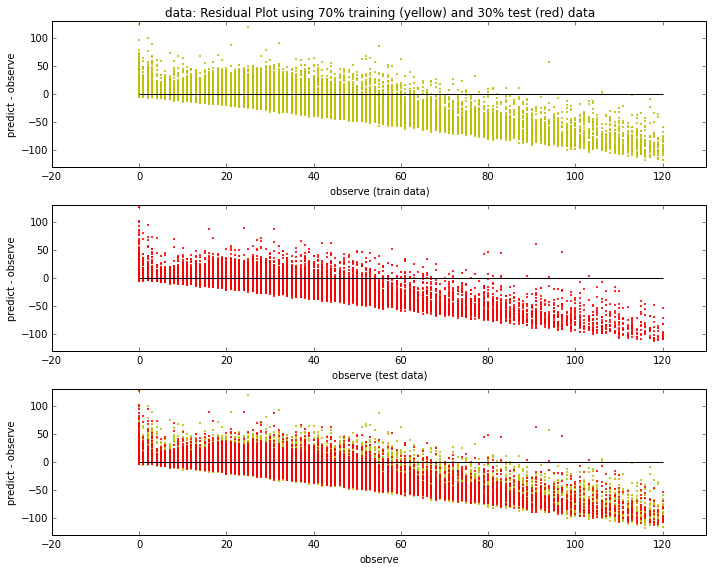

In [47]:
plt.figure(1)

plt.subplot(311)
plt.scatter(y_train, lm1.predict(X_train) - y_train, c='y', s=1,edgecolor='y')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.title('data: Residual Plot using 70% training (yellow) and 30% test (red) data')
plt.ylabel('predict - observe')
plt.xlabel('observe (train data)')

plt.subplot(312)
plt.scatter(y_test, lm1.predict(X_test) - y_test, c='r', s=1,edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('predict - observe')
plt.xlabel('observe (test data)')

plt.subplot(313)
plt.scatter(y_train, lm1.predict(X_train) - y_train, c='y', s=1, edgecolor='y')
plt.scatter(y_test, lm1.predict(X_test) - y_test, c='r', s=1, edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('predict - observe')
plt.xlabel('observe')

plt.tight_layout()
plt.figure(figsize=(10,5))
#pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.show()

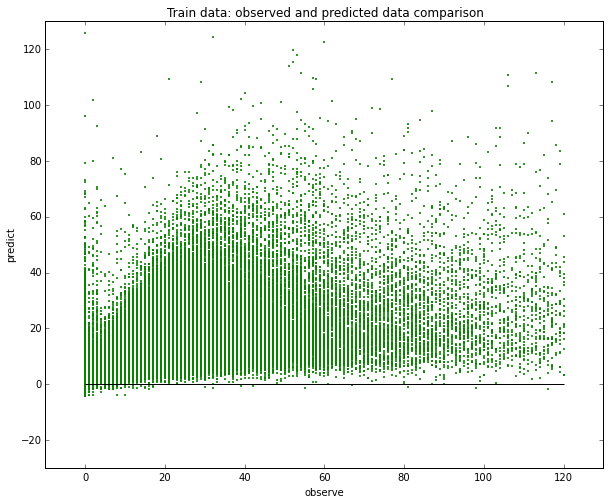

In [48]:
plt.figure(1)

plt.scatter(y_train, lm1.predict(X_train), c='y', s=1,edgecolor='g')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-10, 130, -30, 130])
plt.title('Train data: observed and predicted data comparison')
plt.ylabel('predict')
plt.xlabel('observe')
plt.figure(figsize=(10,5))
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.show()

In [ ]:
x = y_test
y = lm1.predict(X_test)

# Calculate the point density
start = timeit.default_timer()
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
stop = timeit.default_timer()
print 'finished calculating z:', stop - start

# Sort the points by density, so that the densest points are plotted last
start = timeit.default_timer()
idx = z.argsort()
stop = timeit.default_timer()
print 'finished sorting data:', stop - start

x, y, z = x[idx], y[idx], z[idx]
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=5, edgecolor='')
plt.axis([0, 130, 0, 130])
plt.title('Test data: scatter plot colored by density')
plt.ylabel('predict')
plt.xlabel('observe')
plt.show()

# Model 2 - without vehicle IDs 

In [49]:
X2_train = df_train[['on','off','Floor','three_doors','all_door_boarding','Express','OWL','Rapid',
                     'on_threedoors','off_threedoors','on_floor','off_floor',
                     'on_all_door_boarding','off_all_door_boarding','on_express','off_express',
                     'on_rapid','off_rapid','on_owl','off_owl', 'abs_pasg']]

X2_test = df_test[['on','off','Floor','three_doors','all_door_boarding','Express','OWL','Rapid',
                   'on_threedoors','off_threedoors','on_floor','off_floor',
                   'on_all_door_boarding','off_all_door_boarding','on_express','off_express',
                   'on_rapid','off_rapid','on_owl','off_owl', 'abs_pasg']]

y2_train = y_train
y2_test = y_test

In [50]:
lm2 = LinearRegression()
lm2.fit(X2_train, y2_train)
LinearRegression(copy_X=True, fit_intercept=True,normalize=False)

# Construct a data frame that contains features and estimated coefficients
sklearn_results2 = pd.DataFrame(zip(X2_train.columns, lm2.coef_), columns = ['features', 'estimatedCoefficients'])
# p-values
scores, pvalues = chi2(X2_train, y2_train)
sklearn_results2['pvalues'] = pd.DataFrame(pvalues)
sklearn_results2['scores'] = pd.DataFrame(scores)
stop = timeit.default_timer()
print 'build model without veh ids:', stop - start

build model without veh ids: 690.306175611


In [51]:
print sklearn_results2

                 features  estimatedCoefficients  pvalues     scores
0                      on                  2.102    0.000 541656.128
1                     off                  1.246    0.000 353034.315
2                   Floor                 -2.319    0.000   3813.096
3             three_doors                  0.709    0.000   4890.690
4       all_door_boarding                 -0.702    0.525    118.351
5                 Express                  0.669    0.000   2445.019
6                     OWL                 -0.816    0.000    312.246
7                   Rapid                  3.939    0.000   4905.830
8           on_threedoors                  0.283    0.000 220865.409
9          off_threedoors                  0.018    0.000 137060.033
10               on_floor                  0.849    0.000  38187.151
11              off_floor                  0.525    0.000  28237.424
12   on_all_door_boarding                  0.207    0.000 249585.216
13  off_all_door_boarding         

In [52]:
sklearn_results2.to_csv('R:/Angela/fast_trips/muni_apc_2012/passenger_var_datasets_withoutVeh_4day_absOnOff_03012016.csv')

In [53]:
# R-square
R22 = r2_score(y_train, pred_train) 
print R22

0.388134046848


# Correlation table

find the top correlations in a correlation matrix with Pandas

In [ ]:
c2 = X2_train.corr().abs()
s2 = c2.unstack()
so2 = s2.order(kind="quicksort")

In [ ]:
print len(so2)
soo2 = so2.dropna()
soo2 = soo2[soo2 >= 0.500]
soo2 = soo2[soo2 != 1.0]
print len(soo2)

In [ ]:
soo2

# Plots

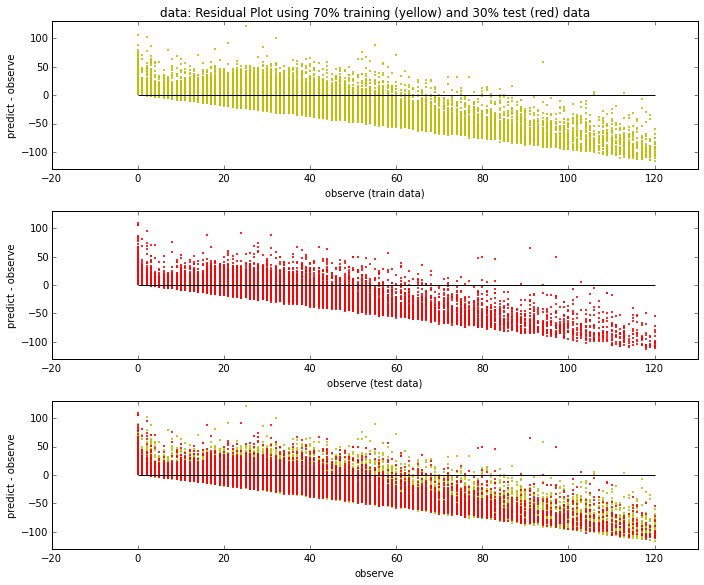

In [54]:
plt.figure(1)
plt.subplot(311)
plt.scatter(y2_train, lm2.predict(X2_train) - y2_train, c='y', s=1,edgecolor='y')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.title('data: Residual Plot using 70% training (yellow) and 30% test (red) data')
plt.ylabel('predict - observe')
plt.xlabel('observe (train data)')

plt.subplot(312)
plt.scatter(y2_test, lm2.predict(X2_test) - y2_test, c='r', s=1,edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('predict - observe')
plt.xlabel('observe (test data)')

plt.subplot(313)
plt.scatter(y2_train, lm2.predict(X2_train) - y2_train, c='y', s=1, edgecolor='y')
plt.scatter(y2_test, lm2.predict(X2_test) - y2_test, c='r', s=1, edgecolor='r')

plt.tight_layout()
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('predict - observe')
plt.xlabel('observe')

plt.show()

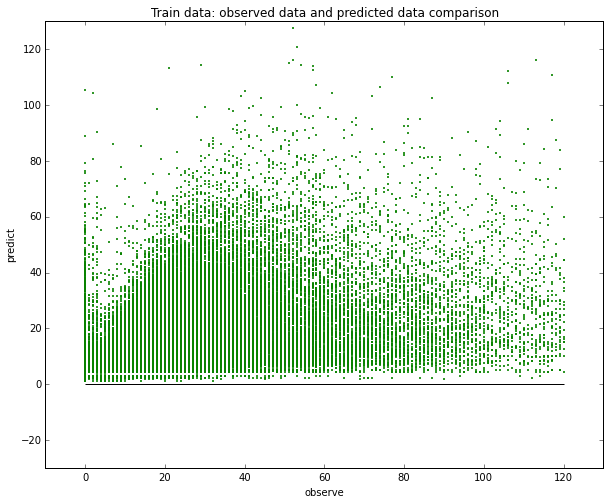

In [55]:
plt.figure(1)

plt.scatter(y2_train, lm2.predict(X2_train), c='y', s=1,edgecolor='g')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-10, 130, -30, 130])
plt.title('Train data: observed data and predicted data comparison')
plt.ylabel('predict')
plt.xlabel('observe')
plt.show()

In [ ]:
x2 = y2_test
y2 = lm2.predict(X2_test)

# Calculate the point density
start = timeit.default_timer()
xy2 = np.vstack([x2,y2])
z2 = gaussian_kde(xy2)(xy2)
stop = timeit.default_timer()
print 'z:', stop - start

# Sort the points by density, so that the densest points are plotted last
start = timeit.default_timer()
idx = z2.argsort()
stop = timeit.default_timer()
print 'sort data:', stop - start

x2, y2, z2 = x2[idx], y2[idx], z2[idx]
fig, ax = plt.subplots()
ax.scatter(x2, y2, c=z2, s=5, edgecolor='')

plt.axis([0, 130, 0, 130])
plt.title('Test dataset: scatter plot colored by density')
plt.ylabel('predict')
plt.xlabel('observe')

plt.show()

In [ ]:
print 'end'